# How the Scientific Python ecosystem helps answering fundamental questions of the Universe

## The LHC and the ATLAS experiment

The ATLAS experiment at CERN explores vast amounts of physics data to answer the most fundamental questions of the Universe.

* What is Dark Matter, and can we produce dark matter particles in the LHC?
* Are there extra spatial dimensions beyond the familiar three?
* Why is there more matter than antimatter in the universe?
* Are there new fundamental particles or forces?
* ...

The Large Hadron Collider (LHC) is a circular particle accelerator that provides high energy proton-proton collisions (_events_), from which new particles are being produced due to the basic equation that relates energy and matter:  
$$E = mc^2$$

![](figures/LHC_collisions.jpeg)

The ATLAS detector is mounted in one of the four interaction points of the LHC -- other detectors are mounted in other interaction points.

![](figures/LHC.png)

Those outgoing, newly produced particles, leave signatures in the ATLAS detector. Physicists reconstruct particle objects from those signatures.

ATLAS is a complex detector, composed by various sub-detectors, each one specialized to the detection of a specific signature/particle.

![](figures/ATLASImage.jpg)

![](figures/Schematic-of-how-different-particles-interact-with-the-ATLAS-detector.png)

## The ATLAS physics data

Those reconstructed particle objects, after various processing and data reduction steps, are stored in a compact data format called [PHYSLITE](https://opendata.atlas.cern/docs/documentation/data_format/physlite/) ($\sim 10\,\text{kB/event}$). Physicists analyze PHYSLITE data to study the properties of the particles produced in each event.

PHYSLITE data are highly structured and can be represented in a tabular format. However, since each event can contain variable number of particles, this will be a _jagged_ table. Learn more about [jagged data](https://en.wikipedia.org/wiki/Jagged_array) in the Part 3 of the tutorial [Thinking In Arrays](https://github.com/ekourlit/scipy2024-tutorial-thinking-in-arrays).

There is a specialized Python library that provides NumPy-like idioms for arbitrary data structures that we will utilize. The [`awkward-array`](https://github.com/scikit-hep/awkward). 

For example:

In [70]:
import awkward as ak

example = ak.Array([
    [{"x": 1.1, "y": 1.2, "z": 3.1}, {"x": 2.2, "y": 1.3, "z": 2}, {"x": 3.3, "y": 2.4, "z": 4.2}],     # this event contains three electrons with properties x, y, and z
    [],                                                                                                 # this event contains no electrons
    [{"x": 4.4, "y": 1.1, "z": 1}, {"x": 5.5, "y": 4.2, "z": 3.2}]                                      # this event contains two electrons with properties x, y, and z
])

ak.to_dataframe(example)

x    y    z
entry subentry               
0     0         1.1  1.2  3.1
      1         2.2  1.3  2.0
      2         3.3  2.4  4.2
2     0         4.4  1.1  1.0
      1         5.5  4.2  3.2

What is well defined are the properties of the particles we store in PHYSLITE files. Those are all listed in:

https://atlas-physlite-content-opendata.web.cern.ch/

ATLAS has recently released 65 TB of PHYSLITE open data for research -- this is over 7 billion LHC collision events! Those are all the data collected by the experiment during the 2015 and 2016. The release is accompanied by additional 2 billion events of simulated “Monte Carlo” data, which are essential for carrying out a physics analysis. The simulated data have largely the same structure as the real data. We're going to use these simulated events for today's demonstration for practical purposes.

Read about our open data release at: 

https://atlas.cern/Updates/News/Open-Data-Research

Our open data portal provides in depth information about the data along with analysis tutorials:

https://opendata.atlas.cern/

## Reading PHYSLITE files

PHYSLITE files are of type [ROOT](https://root.cern/) files. This is a very common file type used in particle physics and needs specialized decompression and deserialization routines to load the data in memory (e.g. awkward arrays). For such purpose we will use the [`uproot`](https://github.com/scikit-hep/uproot5) library.

So now we have introduced the two main libraries we utilize for particle physics data analysis in the Scientific Python ecosystem:
1. `awkward`
2. `uproot`

Those two libraries are in principle enough for a physicist to acquire an in-memory representation of the data. However, to make our life easier we will use an additional library which is build on top of `awkward` and `uproot`. This is called [`coffea`](https://github.com/CoffeaTeam/coffea) and provides basic tools and wrappers for all the typical needs of particle physics data analysts who use the Scientific Python ecosystem.

Let's import some required classes and functions from `coffea` along with `numpy`.

In [33]:
from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea.analysis_tools import PackedSelection
from coffea import dataset_tools
import numpy as np

## Analysis introduction

The particular analysis case we will use for this demonstration is the search for the Higgs boson, an elementary particle discovered in 2012. The Higgs boson was predicted by the BEH mechanism, the mechanism that explains how all the particles in the Universe acquire mass. The discovery of the Higgs boson by the ATLAS and CMS experiments at CERN awarded the Nobel prize for physics to Francois Englert and Peter W. Higgs in 2013. Read more about this landmark discovery here:

https://atlas.cern/Discover/Physics/Higgs

The Higgs boson is produced by the proton-proton collisions of the LHC. However, it is extremely short lived (about $10^{-22}$ seconds) and immediately decays to other particles. For this scenario we will study the decays of the Higgs boson to two other elementary particles, the Z bosons. In their turn, Z bosons are extremely short lived as well but they can decay at about 3% of the time to two electrons. Electrons are also elementary particle but stable ones! Therefore we will look at our detector for electron signatures. In particular four electrons.

![Alt text](figures/fig_01d.png)

In [73]:
# Hgg -> 4l sample

# local
# file_path = '/Users/ekourlitis/cernbox/mc20_13TeV.345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.deriv.DAOD_PHYSLITE.e7735_s3681_r13167_p6026/mc20_13TeV/DAOD_PHYSLITE.38191712._000020.pool.root.1'

# UChicago
file_path = 'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000001.pool.root.1'

In [74]:
def filter_name(name):
    return name in [
        "AnalysisElectronsAuxDyn.pt",
        "AnalysisElectronsAuxDyn.eta",
        "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m",
        "AnalysisElectronsAuxDyn.DFCommonElectronsLHLoose",
        "AnalysisElectronsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000",
        "AnalysisElectronsAuxDyn.topoetcone20",
        "AnalysisElectronsAuxDyn.charge",
        "AnalysisMuonsAuxDyn.pt",
        "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi",
        "AnalysisMuonsAuxDyn.m",
        "AnalysisMuonsAuxDyn.quality",
        "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000",
        "AnalysisMuonsAuxDyn.topoetcone20",
    ]

events = NanoEventsFactory.from_root(
    {file_path: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    uproot_options=dict(filter_name=filter_name)
).events()

/venv/lib/python3.9/site-packages/coffea/util.py:234: UserWarning: Skipping xTrigDecisionAux.xAOD::AuxInfoBase as it is not interpretable by Uproot
  warnings.warn(
/venv/lib/python3.9/site-packages/coffea/util.py:234: UserWarning: Skipping METAssoc_AnalysisMETAux.xAOD::AuxContainerBase as it is not interpretable by Uproot
  warnings.warn(
/venv/lib/python3.9/site-packages/coffea/util.py:234: UserWarning: Skipping AntiKt10TruthSoftDropBeta100Zcut10JetsAux.xAOD::AuxContainerBase as it is not interpretable by Uproot
  warnings.warn(
/venv/lib/python3.9/site-packages/coffea/util.py:234: UserWarning: Skipping AntiKt10UFOCSSKJetsAux.xAOD::AuxContainerBase as it is not interpretable by Uproot
  warnings.warn(
/venv/lib/python3.9/site-packages/coffea/util.py:234: UserWarning: Skipping AntiKt4TruthDressedWZJetsAux.xAOD::AuxContainerBase as it is not interpretable by Uproot
  warnings.warn(
/venv/lib/python3.9/site-packages/coffea/util.py:234: UserWarning: Skipping EventInfoAuxDyn.hardScatterVe

# Highly structured jagged data

In [75]:
events.fields

['Electrons', 'Muons']

In [76]:
events.Electrons.compute()

<ElectronArray [[Electron, ..., Electron], ...] type='50000 * var * electron'>

# Data selection and feature engineering

In [77]:
def object_selection(events):
    '''
    Select objects based on kinematic and quality criteria
    '''
    
    electrons = events.Electrons
    muons = events.Muons
    
    electron_reqs = (electrons.pt > 20) & \
                    (np.abs(electrons.eta) < 2.47) & \
                    (electrons.DFCommonElectronsLHLoose == 1) & \
                    (electrons.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000/electrons.pt < 0.15) & \
                    (electrons.topoetcone20/electrons.pt < 0.2)
                    
    # add quality requirements here
    muon_reqs = (muons.pt > 20) & \
                (np.abs(muons.eta) < 2.7) & \
                (muons.quality == 2) & \
                (muons.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000/muons.pt < 0.15) & \
                (muons.topoetcone20/muons.pt < 0.3)
    
    # only keep objects that pass our requirements
    electrons = electrons[electron_reqs]
    muons = muons[muon_reqs]
    
    return electrons, muons

def region_selection(electrons, muons):
    '''
    Select events based on object multiplicity
    '''
    
    selections = PackedSelection(dtype='uint64')
    # basic selection criteria
    selections.add("exactly_4e", ak.num(electrons) == 4)
    selections.add("total_e_charge_zero", ak.sum(electrons.charge, axis=1) == 0)
    selections.add("exactly_0m", ak.num(muons) == 0)
    # selection criteria combination
    selections.add("4e0m", selections.all("exactly_4e", "total_e_charge_zero", "exactly_0m"))
    
    return selections.all("4e0m")

def calculate_inv_mass(electrons):
    '''
    Construct invariant mass observable
    '''
    
    # reconstruct Higgs as 4e system
    candidates = ak.combinations(electrons, 4)
    e1, e2, e3, e4 = ak.unzip(candidates)
    candidates["p4"] = e1 + e2 + e3 + e4
    higgs_mass = candidates["p4"].mass
    observable = ak.flatten(higgs_mass/1000)
    
    return observable

In [78]:
# select objects and events
el, mu = object_selection(events)
selection_4e0m = region_selection(el, mu)

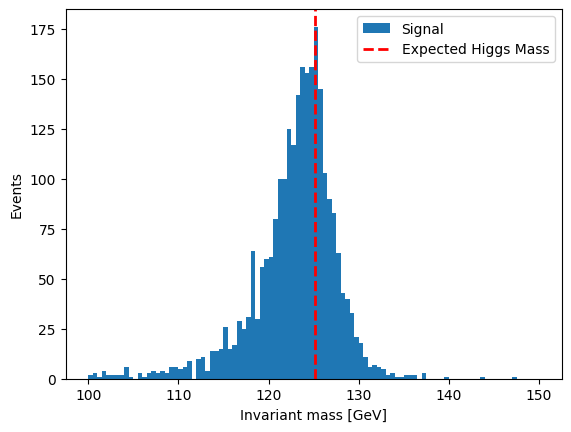

In [79]:
from matplotlib import pyplot as plt
import hist
import dask

# observable calculation and plotting
plt.hist(calculate_inv_mass(el[selection_4e0m]).compute(), bins=100, range=(100, 150), label='Signal')
plt.axvline(125.11, color='r', linestyle='dashed', linewidth=2, label='Expected Higgs Mass')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Events')
plt.legend()
plt.show()

In [81]:
file_list = ['root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000001.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000002.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000005.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000006.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000007.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000008.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000009.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000010.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000011.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000012.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000013.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000014.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000016.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000017.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000018.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000019.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000020.pool.root.1',
'root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37110937._000011.pool.root.1']

for file in file_list:
    events = NanoEventsFactory.from_root(
    {'root://xcache.af.uchicago.edu:1094//'+file: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    uproot_options=dict(filter_name=filter_name)).events()

    number_of_events = len(events.compute())
    print(f"file {file.split('/')[-1]} has {number_of_events} events")

file DAOD_PHYSLITE.38191712._000001.pool.root.1 has 50000 events
file DAOD_PHYSLITE.38191712._000002.pool.root.1 has 50000 events
file DAOD_PHYSLITE.38191712._000005.pool.root.1 has 50000 events
file DAOD_PHYSLITE.38191712._000006.pool.root.1 has 40000 events
file DAOD_PHYSLITE.38191712._000007.pool.root.1 has 40000 events
file DAOD_PHYSLITE.38191712._000008.pool.root.1 has 40000 events
file DAOD_PHYSLITE.38191712._000009.pool.root.1 has 40000 events
file DAOD_PHYSLITE.38191712._000010.pool.root.1 has 40000 events
file DAOD_PHYSLITE.38191712._000011.pool.root.1 has 150000 events
file DAOD_PHYSLITE.38191712._000012.pool.root.1 has 150000 events
file DAOD_PHYSLITE.38191712._000013.pool.root.1 has 170000 events
file DAOD_PHYSLITE.38191712._000014.pool.root.1 has 160000 events
file DAOD_PHYSLITE.38191712._000016.pool.root.1 has 160000 events
file DAOD_PHYSLITE.38191712._000017.pool.root.1 has 158000 events
file DAOD_PHYSLITE.38191712._000018.pool.root.1 has 140000 events
file DAOD_PHYSLITE

# Scale out processing over multiple files

In [82]:
# local
# fileset = {"ZZ"     : {'files': {'/Users/ekourlitis/cernbox/mc20_13TeV.700600.Sh_2212_llll.deriv.DAOD_PHYSLITE.e8433_s3681_r13167_p6026/mc20_13TeV/DAOD_PHYSLITE.37110926._000047.pool.root.1' : "CollectionTree"},
#                       'metadata': {'process': 'ZZ', 'xsec': 1.2973999999999999, 'nevts': 67558600}},
#            "Higgs"  : {'files': {'/Users/ekourlitis/cernbox/mc20_13TeV.345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.deriv.DAOD_PHYSLITE.e7735_s3681_r13167_p6026/mc20_13TeV/DAOD_PHYSLITE.38191712._000020.pool.root.1' : "CollectionTree"}, 
#                       'metadata': {'process': 'Higgs', 'xsec': 28.299999999999997, 'nevts': 6500000}},}

# UChicago
fileset = {
           "ZZ"     : {
                        'files': {'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37110937._000011.pool.root.1' : 'CollectionTree'},
                        'metadata': {'process': 'ZZ', 'xsec': 1.297, 'genFiltEff': 1.0, 'kFactor': 1.0, 'nevts': 250000}
                      },
    
           "Higgs"  : {
                        'files': {'root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191712._000001.pool.root.1' : 'CollectionTree'}, 
                        'metadata': {'process': 'Higgs', 'xsec': 28.3, 'genFiltEff': 1.240E-04, 'kFactor': 1.45, 'nevts': 50000}
                      }
          }

# pre-process
samples, _ = dataset_tools.preprocess(fileset)

In [83]:
# create histogram with observables
def create_histogram(events):
    hist_4e0m = (
        hist.dask.Hist.new.Reg(100, 100, 150, name='m_eeee', label=r"$m_{eeee}$ [GeV]")
        .StrCat([], name='process', label='Process', growth=True)
        .Weight()
    )

    process = events.metadata['process']

    # normalization for MC
    x_sec = events.metadata["xsec"]
    gen_filt_eff = events.metadata["genFiltEff"]
    k_factor = events.metadata["kFactor"]
    nevts_total = events.metadata["nevts"]
    lumi = 36000. # /pb
    
    if process != "data":
        xsec_weight = x_sec * gen_filt_eff * k_factor * lumi / nevts_total
    else:
        xsec_weight = 1
        
    print(f"Processing {process} with xsec weight {xsec_weight}")

    # select objects and events
    el, mu = object_selection(events)
    selection_4e0m = region_selection(el, mu)

    # observable calculation and histogram filling
    inv_mass = calculate_inv_mass(el[selection_4e0m])
    hist_4e0m.fill(inv_mass, weight=xsec_weight, process=process)

    return {"4e0m": hist_4e0m}

In [84]:
# create the task graph
tasks = dataset_tools.apply_to_fileset(create_histogram, 
                                       samples, 
                                       schemaclass=PHYSLITESchema,
                                       uproot_options=dict(filter_name=filter_name))

Processing ZZ with xsec weight 0.186768
Processing Higgs with xsec weight 0.0036636048


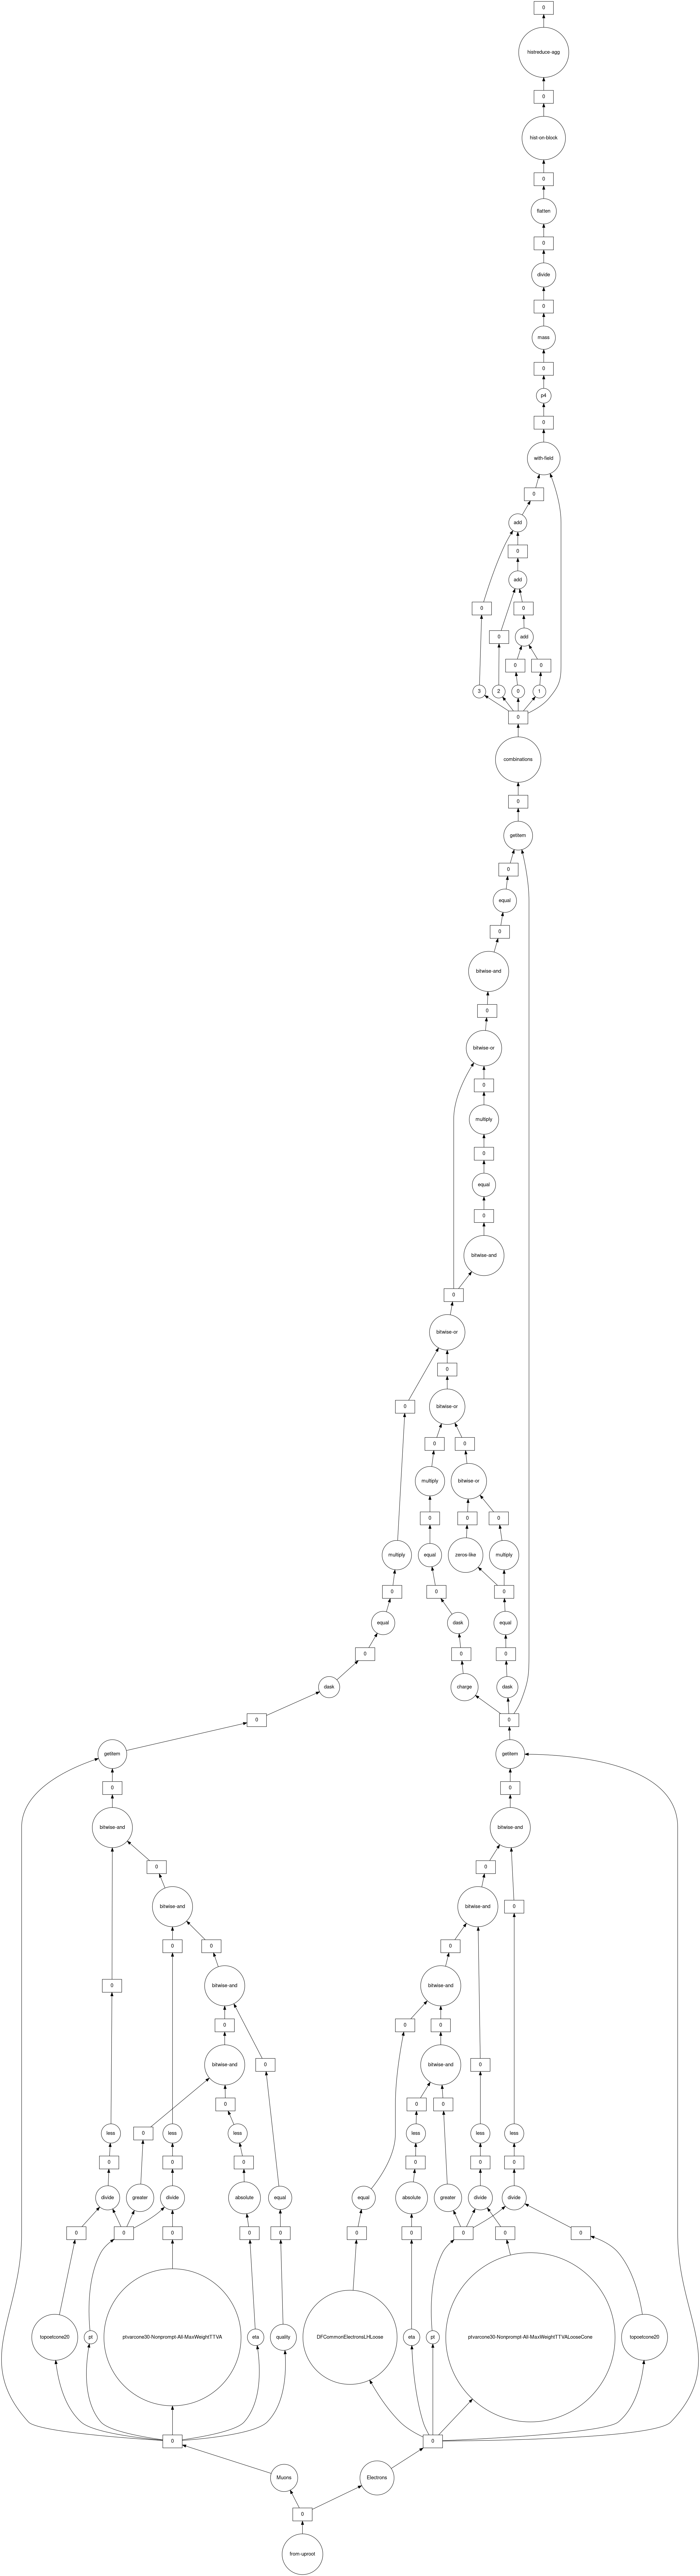

In [85]:
# visualise the task graph
tasks["Higgs"]["4e0m"].visualize()

In [86]:
%%time
# execute
(out, ) = dask.compute(tasks)

CPU times: user 8.29 s, sys: 358 ms, total: 8.65 s
Wall time: 8.36 s


In [87]:
# stack all the histograms together, as we processed each sample separately
full_histogram = sum([v["4e0m"] for v in out.values()])

Text(0, 0.5, 'Events')

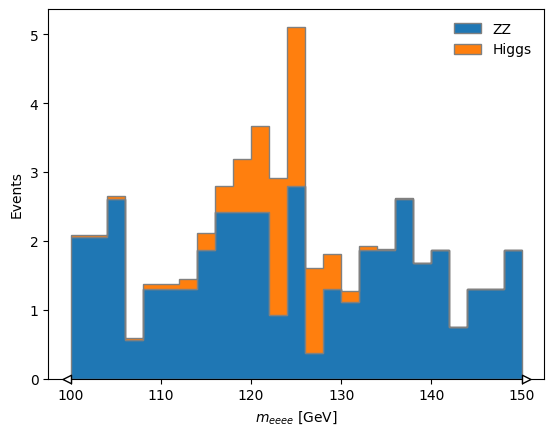

In [88]:
artists = full_histogram[hist.rebin(4), :].stack("process").plot(
    stack=True, histtype="fill", linewidth=1, edgecolor="grey")

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)
# ax.set_yscale("log")
ax.set_ylabel("Events")